Environment Information:
* Win10 x64
* Python 3.8.8
* `numpy==1.19.2`
* `pandas==1.3.2`
* `fastparquet==0.7.1`
* `joblib==1.0.1`
* `scikit-learn==0.24.2`
* `tensorflow==2.5.0`
* `keras==2.4.3`

# Table of Contents
* Introduction
	* Recommendation Framework Overview
	* Recommender Model
	* Other Potential Directions & Challenges
* Load and Transform Data
	* User-Merchant Rating
	* Preprocessing
	* Split Train and Test Sets
* Build Model and Evaluate Performance
	* Train Model
	* Evaluate Model Performance
	* Test Performance
	* Train Performance
* Train Final Model
	* Cache Application Components
* Appendix: recommend top 3 merchants to a given user

# Introduction

In this notebook, I will
1. Evaluate the performance of a merchant recommender on train and test sets.
2. Train a final model for serving as an API.

<br>

## Recommendation Framework Overview
For an **existing user**, the recommender system will recommend totally 5 merchants (without duplication):
* 3 merchants from the machine learning model
    * A collaberative filtering recommender model with matrix factorization, implemented in Keras API.
* 1 "trending" merchant, which increased popularity recently (randomly select from top 5)
* 1 new merchant, which opened a new store recently (randomly select from top 5)

Recommendations from the machine learning model will be evaluated.<br>
On the other hand, the trending and new merchant recommendations will not be evaluated, as they are more for diversity.

<br>

For a **new user**, the recommender system will recommend totally 5 merchants (without duplication):
* 3 popular merchants (randomly select from top 10)
* 1 "trending" merchant, which increased popularity recently (randomly select from top 5)
* 1 new merchant, which opened a new store recently (randomly select from top 5)

<br>

## Recommender Model
Althrough the EDA has shown that this dataset is suitable for item-based CF, in this exerice I will try out a matrix factorization approach based on Keras.<br>
For the given data set, this approach resulted in poor diversity. As a result, the "trending" and "new" recommendations, as stated above, are incorporated to improve the diversity.

<br>

## Other Potential Directions & Challenges
The current solution could face some potential challenges, which are not addressed in this exercise, including:
* Handle extremely unpopular merchats, or users with few clicks
* Diversity fo recommendation / echo chamber
* Potential shilling attack in the data set
* Large size of the model
* ...

There are other potentail directions, which are not included in this exercise, including:
* Do not recommend closed stores.
    * In described in EDA, there are no closed stores in this data set
* Do not recommend most recently interacted merchant.
* Recommendation based on device / platform / channel.
* Performance tuning / comparision with other models such as item-based CF, ALS based matrix factorization, etc.
* Use-case variations (push notification, email subscription, categoies on webpage, etc).
* ...

In addition, the potential performance issue from discount count operations won't be addressed here. 

# Load and Transform Data

In [1]:
import numpy as np
import pandas as pd
np.random.seed(0)

colsClicks = ['timestamp', 'user_id', 'store_id']
dfClicks = pd.read_parquet('data/clicks.parquet', engine='fastparquet')[colsClicks]
dfClicks['timestamp'] = pd.to_datetime(dfClicks['timestamp'])
dfClicks = dfClicks[(dfClicks['timestamp']>='2021-01-01') & (dfClicks['timestamp']<'2021-04-01')].reset_index(drop=True)
print(f"Clicks data contains {len(dfClicks)} rows from {dfClicks['user_id'].nunique()} users, {dfClicks['store_id'].nunique()} stores, over {dfClicks['timestamp'].min()} to {dfClicks['timestamp'].max()}")

colsStores = ['store_id', 'merchant_id', 'start_date']
dfStores = pd.read_parquet('data/stores.parquet', engine='fastparquet')[colsStores]
dfStores['start_date'] = pd.to_datetime(dfStores['start_date'])
print(f"Stores data contains {len(dfStores)} rows from {dfStores['store_id'].nunique()} stores, {dfStores['merchant_id'].nunique()} marchants from {dfStores['start_date'].min().date()}")

dfClicks = dfClicks.merge(dfStores, 'left', 'store_id')
dfClicks['date'] = pd.to_datetime(dfClicks['timestamp'].dt.date)
dfClicks.head(3)

Clicks data contains 1846145 rows from 103806 users, 403 stores, over 2021-01-01 00:00:15 to 2021-03-31 00:00:00
Stores data contains 537 rows from 537 stores, 497 marchants from 2020-03-02


,timestamp,user_id,store_id,merchant_id,start_date,date
0,2021-02-03 23:47:27,28349,366,345,2020-03-02,2021-02-03
1,2021-03-07 15:52:05,3553,424,398,2021-05-05,2021-03-07
2,2021-03-09 13:17:56,53657,165,159,2020-04-29,2021-03-09


## User-Merchant Rating
A **user-merchant rating** for each user-merchant pair with interactions, will be formulated with the following considerations:
* Account for both **recency** (time decay) and **frequency** (level of interaction)
* **Bounded**
    * Non-negative
    * Prevent extremely high ratings from very frequent user-machent interactions
* **Penalize very popular merchants** to improve diversity
* Simple to illustrate, for the purpose of this exercise

<br>

**Formulation**: the rating will be calculated in the following steps:
1. **Date Aggregation**: Aggregate to "dates in which each user had clicked on each merchant"
2. **Linear Time Decay**: Map each interacted dates by a linear rating (time decay): 6 (most recent) to 0 (60 days ago)
    * rating = 6 - 0.1 * N days ago
    * If more than 60 days ago, rating = 0
3. **Date-Group Aggregation**: For the past 0-29 and 30-59 days, take only the maximum rating (per user, merchant, date-group)
4. **User-Merchant Aggregation**: Sum up the total rating (per user, merchant)
5. **Linear Popularity Penalty**
    * Measure popularity by *LOG(total number of users clicked)*
    * Map to a linear penalty factor: 0.5 (max_popularity) to 1 (0)
        * max_popularity is the popularity of the merchant visited by most users.
    * penalty_factor = 1  -  0.5 \* popularity_of_the_merchant / max_popularity
6. **Apply Popularity Penalty**: final rating = rating * penalty_factor

<br>

For example, interaction between user *U* and merchant *M*:
1. dates with clicks: 2021-01-30, 2021-02-15, 2021-03-01, 2021-03-22, 2021-03-31
2. Map to the linear rating:
    * N days ago: 60, 44, 30, 9, 0
    * rating: 0.0, 1.6, 3.0, 5.1, 6.0
3. For the past 0-29 and 30-59 days, take only the maximum rating
    * 0-29 group: maximum rating = 6.0
    * 30-59 group: maximum rating = 3.0
4. Sum up the total rating = 6 + 3 = 9
5. Say, the popularity penalty of merchant M has been calculated as 0.8
6. final rating of U-M = 9 * 0.8 = 7.2

<br>

With this formulation
* Theoretically, **9** is the maximum rating a user-merchant pair could get, and **0** is the minimum.
* As a result, when doing min-max scaling of the rating, I will use 0 and 9 respectively, instead of the min-max values of the training data set.

In [2]:
from pandas import DateOffset

POPULARITY_PANALTY = 0.5

def GenerateRatingData(dfClicks, dateNow, fPopularityPanalty=POPULARITY_PANALTY):
    dateLower = dateNow - DateOffset(59)
    
    # step 1 - Date Aggregation
    indexSelect = (dfClicks['timestamp'] <= dateNow) & (dfClicks['timestamp'] >= dateLower)
    colsSelect = ['user_id', 'merchant_id', 'date']
    dfRating = dfClicks[indexSelect][colsSelect].drop_duplicates().reset_index(drop=True)
    print(f"Ratings data contains {len(dfRating)} rows from {dfRating['user_id'].nunique()} users, {dfRating['merchant_id'].nunique()} marchants over {dfRating['date'].min().date()} to {dfRating['date'].max().date()}.")

    # step 2 - Linear Time Decay
    dfRating['n_days_ago'] = (dateNow - dfRating['date']).dt.days
    dfRating['rating'] = 6 - 0.1*dfRating['n_days_ago']
    indexNeg = dfRating['rating']<0
    dfRating.loc[indexNeg, 'rating'] = 0

    # step 3 - Date-Group Aggregation
    dfRating['date_group'] = pd.cut(dfRating['rating'], bins=[0, 3, 6], labels=[1,2]).astype(int)
    dfRating = dfRating.groupby(['user_id', 'merchant_id', 'date_group'])['rating'].max().reset_index()

    # step 4 - User-Merchant Aggregation
    dfRating = dfRating.groupby(['user_id', 'merchant_id'])['rating'].sum().reset_index()
    print(f"Range of user-merchant rating in the resulted data is from {dfRating['rating'].min():.1f} to {dfRating['rating'].max():.1f}")

    # step 5 - Linear Popularity Penalty
    dfMerchantPopularity = dfRating.groupby('merchant_id').size().apply(np.log).rename('popularity').reset_index()
    dfMerchantPopularity['penalty_factor'] = 1 - fPopularityPanalty*dfMerchantPopularity['popularity']/dfMerchantPopularity['popularity'].max()
    
    # step 6 - Apply Popularity Penalty
    dfRating = dfRating.merge(dfMerchantPopularity, 'left', 'merchant_id')
    dfRating['rating'] = dfRating['rating']*dfRating['penalty_factor']
    
    return dfRating


## Preprocessing

Two preprocessing steps will be carried out:
1. Encoding user and merchant with integer index (to support Keras Embedding)
2. Min-Max Scaling to fit ratings to sigmoid activation function
    * As explain in the previous section, the rating is formulated to use pre-defined min-max values.

In [3]:
from sklearn.preprocessing import LabelEncoder

encUser = LabelEncoder()
encMerchant = LabelEncoder()

In [4]:
class FixedMinMaxScaler():
    def __init__(self, min_value, max_value):
        self.min = min_value
        self.max = max_value
    
    def transform(self, ar):
        return (ar - self.min) / (self.max - self.min)
    
    def inverse_transform(self, ar):
        return ar*(self.max - self.min) + self.min

scaler = FixedMinMaxScaler(0, 9)

## Split Train and Test Sets

The given data set is from 2021-Jan to 2021-Mar
* Train set: user-merchant rating as of end of 2021-Feb
* Test set: user-merchant rating as of end of 2021-Mar

This train-test split would arguably cause data leaking in the given data.<br>
While I won't address much into this issue for this exercise.

<br>

**Unpopular Merchants and Inactive Users:**
* Users who had clicked on only 1 merchant recently, as well as merchants which got clicked only by 1 user recently, are not suitable for this model.
* Although technically the model can still provide recommendations to such users, in this exercise, I will exclude such users and merchants in model training and validation.

In [5]:
def FilterActiveUsersMerchants(df):
    seUserMerchants = df.groupby('user_id')['merchant_id'].nunique()
    seMerchantUsers = df.groupby('merchant_id')['user_id'].nunique()
    indexSelectUser = df['user_id'].isin(list(seUserMerchants[seUserMerchants>1].index))
    indexSelectMerchant = df['merchant_id'].isin(list(seMerchantUsers[seMerchantUsers>1].index))
    return df[indexSelectUser & indexSelectMerchant]

In [6]:
# Keep the train and test dataframes to be used in validation
TRAIN_DATE = pd.to_datetime('2021-02-28')
TEST_DATE = pd.to_datetime('2021-03-31')

print('Train Set:')
dfTrain = GenerateRatingData(dfClicks, TRAIN_DATE)
dfTrain = FilterActiveUsersMerchants(dfTrain)
dfTrain['user_index'] = encUser.fit_transform(dfTrain['user_id'])
dfTrain['merchant_index'] = encMerchant.fit_transform(dfTrain['merchant_id'])
print(f"Filtered data contains {len(dfTrain)} rows from {dfTrain['user_id'].nunique()} users, {dfTrain['merchant_id'].nunique()} merchants.")

print('\nTest Set:')
dfTest = GenerateRatingData(dfClicks, TEST_DATE)
dfTest = FilterActiveUsersMerchants(dfTest)
dfTest = dfTest[dfTest['user_id'].isin(encUser.classes_) & dfTest['merchant_id'].isin(encMerchant.classes_)]
dfTest['user_index'] = encUser.transform(dfTest['user_id'])
dfTest['merchant_index'] = encMerchant.transform(dfTest['merchant_id'])
print(f"Filtered data contains {len(dfTest)} rows from {dfTest['user_id'].nunique()} users, {dfTest['merchant_id'].nunique()} merchants.")

# For model
XTrain, yTrain = dfTrain[['user_index', 'merchant_index']].values, dfTrain['rating'].values
XTest, yTest = dfTest[['user_index', 'merchant_index']].values, dfTest['rating'].values

print('')
print(f"Train set size: X = {XTrain.shape}, y = {yTrain.shape}")
print(f"Test set size: X = {XTest.shape}, y = {yTest.shape}")

# More standardization to fit in sigmoid activation function
yTrain = scaler.transform(yTrain)
yTest = scaler.transform(yTest)

Train Set:
Ratings data contains 654378 rows from 86376 users, 382 marchants over 2021-01-01 to 2021-02-27.
Range of user-merchant rating in the resulted data is from 0.2 to 8.9
Filtered data contains 272820 rows from 57781 users, 373 merchants.

Test Set:
Ratings data contains 645022 rows from 87976 users, 379 marchants over 2021-01-31 to 2021-03-31.
Range of user-merchant rating in the resulted data is from 0.1 to 9.0
Filtered data contains 221491 rows from 44689 users, 364 merchants.

Train set size: X = (272820, 2), y = (272820,)
Test set size: X = (221491, 2), y = (221491,)


# Build Model and Evaluate Performance
## Train Model

In [7]:
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.layers import Dot, Add, Activation
from keras.optimizers import Adam

class Recommender(Model):
    def __init__(self, nUsers, nMerchants, nFactors):
        super(Recommender, self).__init__()
        self.embeddingUser = Embedding(
            nUsers,
            nFactors,
            embeddings_initializer='he_normal',
            embeddings_regularizer=l2(1e-6)
        )
        self.biasUser = Embedding(nUsers, 1)
        
        self.embeddingMerchants = Embedding(
            nMerchants,
            nFactors,
            embeddings_initializer='he_normal',
            embeddings_regularizer=l2(1e-6)
        )
        self.biasMerchants = Embedding(nMerchants, 1)
        
    def call(self, arInput):
        vecUser = self.embeddingUser(arInput[:,0])
        biasUser = self.biasUser(arInput[:,0])
        vecMerchants = self.embeddingMerchants(arInput[:,1])
        biasMerchants = self.biasMerchants(arInput[:,1])
        
        x = Dot(axes=1)([vecUser, vecMerchants])
        x = Add()([x, biasUser, biasMerchants])
        x = Activation('sigmoid')(x)
        return x


In [8]:
EMBEDDING_SIZE = 50

nUsers = len(encUser.classes_)
nMerchants = len(encMerchant.classes_)

model = Recommender(nUsers, nMerchants, EMBEDDING_SIZE)
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0005))

fitHistory = model.fit(
    x=XTrain,
    y=yTrain,
    batch_size=1024,
    epochs=5,
    verbose=1,
    validation_data=(XTest, yTest),
)


Epoch 1/5
267/267 [==============================] - 8s 26ms/step - loss: 0.0713 - val_loss: 0.0824
Epoch 2/5
267/267 [==============================] - 7s 25ms/step - loss: 0.0500 - val_loss: 0.0532
Epoch 3/5
267/267 [==============================] - 7s 25ms/step - loss: 0.0285 - val_loss: 0.0376
Epoch 4/5
267/267 [==============================] - 7s 25ms/step - loss: 0.0198 - val_loss: 0.0346
Epoch 5/5
267/267 [==============================] - 7s 25ms/step - loss: 0.0170 - val_loss: 0.0341


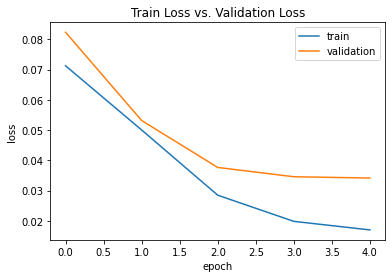

In [9]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(fitHistory.history['loss'])
plt.plot(fitHistory.history['val_loss'])
plt.title('Train Loss vs. Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate Model Performance

I will evaluate the model's performance using **Normalized Discounted Cumulative Gain (NDCG)**

<br>

As described in section *Recommendation Framework Overview*, 3 recommendations for each user will be generated from this model.<br>
As a result, I will evaluate performance
* based on the top 3 recommendations
* only using data from users who have clicked on at least 3 merchants

In [10]:
from sklearn.metrics import ndcg_score

TOP_N = 3

def CalcNDCG(df, colActual='rating', colPred='pred_score', k=TOP_N):
    ar = df[[colActual, colPred]].values.T
    return ndcg_score([ar[0]], [ar[1]], k=k, ignore_ties=False)


## Test Performance

In [11]:
dfTest['pred_score'] = model.predict(XTest).flatten()

## Filter for user who clicked at least 3 merchants
seUserMerchantsCount = dfTest.groupby('user_index').size()
indexSelect = dfTest['user_index'].isin(seUserMerchantsCount[seUserMerchantsCount>=TOP_N].index)
print(f"{indexSelect.sum()} rows from {len(dfTest)} rows are by users clicked at least {TOP_N} merchants.")

ndcgTest = dfTest[indexSelect].groupby(['user_index']).apply(CalcNDCG).mean()
print(f"Average NDCG of test set = {ndcgTest:.2f}")

198765 rows from 221491 rows are by users clicked at least 3 merchants.
Average NDCG of test set = 0.81


## Train Performance

For reference

In [12]:
dfTrain['pred_score'] = model.predict(XTrain).flatten()

## Filter for user who clicked at least 3 merchants
seUserMerchantsCount = dfTrain.groupby('user_index').size()
indexSelect = dfTrain['user_index'].isin(seUserMerchantsCount[seUserMerchantsCount>=TOP_N].index)
print(f"{indexSelect.sum()} rows from {len(dfTrain)} rows are by users clicked at least {TOP_N} merchants.")

ndcgTrain = dfTrain[indexSelect].groupby(['user_index']).apply(CalcNDCG).mean()
print(f"Average NDCG of train set = {ndcgTrain:.2f}")

238643 rows from 272820 rows are by users clicked at least 3 merchants.
Average NDCG of train set = 0.90


# Train Final Model

Train the final model to make recommendation.

In [13]:
TODAY = pd.to_datetime('2021-03-31')

dfTrainFinal = GenerateRatingData(dfClicks, TODAY)
dfTrainFinal = FilterActiveUsersMerchants(dfTrainFinal)
dfTrainFinal['user_index'] = encUser.fit_transform(dfTrainFinal['user_id'])
dfTrainFinal['merchant_index'] = encMerchant.fit_transform(dfTrainFinal['merchant_id'])
print(f"Filtered data contains {dfTrainFinal.shape[0]} rows from {dfTrainFinal['user_id'].nunique()} users, {dfTrainFinal['merchant_id'].nunique()} merchants.")

# For model
XTrainFinal, yTrainFinal = dfTrainFinal[['user_index', 'merchant_index']].values, dfTrainFinal['rating'].values
print(f"Final train set size: X = {XTrainFinal.shape}, y = {yTrainFinal.shape}")

# More standardization to fit in sigmoid activation function
yTrainFinal = scaler.transform(yTrainFinal)

# Train model
fitHistoryFinal = model.fit(
    x=XTrainFinal,
    y=yTrainFinal,
    batch_size=1024,
    epochs=5,
    verbose=1
)

Ratings data contains 645022 rows from 87976 users, 379 marchants over 2021-01-31 to 2021-03-31.
Range of user-merchant rating in the resulted data is from 0.1 to 9.0
Filtered data contains 265709 rows from 57224 users, 372 merchants.
Final train set size: X = (265709, 2), y = (265709,)
Epoch 1/5
260/260 [==============================] - 6s 21ms/step - loss: 0.0358
Epoch 2/5
260/260 [==============================] - 6s 21ms/step - loss: 0.0229
Epoch 3/5
260/260 [==============================] - 6s 21ms/step - loss: 0.0196
Epoch 4/5
260/260 [==============================] - 6s 21ms/step - loss: 0.0181
Epoch 5/5
260/260 [==============================] - 5s 21ms/step - loss: 0.0170


## Cache Application Components

Besides the model, I will also save the user and merchant encoders for later tasks.<br>
The min-max scaler does not need to be saved, because it is designed with fixed parameters.

In [14]:
from joblib import dump

model.save('model/merchant_recommender', save_format='tf')

dump(encUser, 'model/user_encoder.joblib')
dump(encMerchant, 'model/merchant_encoder.joblib')

INFO:tensorflow:Assets written to: model/merchant_recommender\assets


['model/merchant_encoder.joblib']

As described in *Recommendation Framework Overview*, I will also recommend "trending", "new" and "popular" merchants.<br>
So I will cache these results first.

In [16]:
# Trending merchant
from pandas import DateOffset

indexLastMonth = dfClicks['timestamp'] >= (TODAY - DateOffset(months=1))
indexLast2Month = (~indexLastMonth) & (dfClicks['timestamp'] >= (TODAY - pd.offsets.DateOffset(months=2)))

dfUsersLastMonth = dfClicks[indexLastMonth].groupby('merchant_id')['user_id'].nunique().rename('n_users_last_month').reset_index()
dfUsersLast2Month = dfClicks[indexLast2Month].groupby('merchant_id')['user_id'].nunique().rename('n_users_last_2month').reset_index()

dfUsersLastMonth = dfUsersLastMonth.merge(dfUsersLast2Month, 'inner', 'merchant_id')
dfUsersLastMonth['dff_users'] = dfUsersLastMonth['n_users_last_month'] - dfUsersLastMonth['n_users_last_2month']
dfUsersLastMonth.sort_values('dff_users', ascending=False, inplace=True)

dfTop5TrendingMerchant = dfUsersLastMonth.head(5)
dfTop5TrendingMerchant.to_parquet('model/top_5_trending_merchant.parquet', engine='fastparquet')
dfTop5TrendingMerchant

,merchant_id,n_users_last_month,n_users_last_2month,dff_users
28,36,16678,13000,3678
256,365,8676,6728,1948
100,144,3000,1208,1792
333,472,1864,349,1515
104,149,4318,3019,1299


In [17]:
# New
indexNew = dfClicks['start_date'].notnull() & (dfClicks['start_date'] <= pd.to_datetime(TODAY))
dfNewMerchant = dfClicks[indexNew].groupby('merchant_id')['start_date'].max().sort_values(ascending=False).reset_index()

dfTop5NewMerchant = dfNewMerchant.head(5)
dfTop5NewMerchant.to_parquet('model/top_5_new_merchant.parquet', engine='fastparquet')
dfTop5NewMerchant

,merchant_id,start_date
0,261,2021-02-24
1,36,2021-02-18
2,91,2021-02-15
3,272,2021-02-15
4,147,2021-02-09


In [18]:
# Popular
dfPopularMerchant = dfClicks.groupby('merchant_id')['user_id'].nunique().rename('n_users').sort_values(ascending=False).reset_index()

dfTop10PopularMerchant = dfPopularMerchant.head(10)
dfTop10PopularMerchant.to_parquet('model/top_10_popular_merchant.parquet', engine='fastparquet')
dfTop10PopularMerchant

,merchant_id,n_users
0,40,38901
1,36,28598
2,398,21893
3,271,20730
4,490,19440
5,365,17319
6,397,14337
7,347,12009
8,270,9296
9,149,8102


# Appendix: recommend top 3 merchants to a given user

In [19]:
def RecommendToUser(userId):
    # Prepare input array
    arUserIndex = encUser.transform([userId])
    arAllMerchantIndex = encMerchant.transform(encMerchant.classes_)

    arUserMerchantIndex = np.hstack((
        [arUserIndex]*len(arAllMerchantIndex),
        arAllMerchantIndex.reshape(-1,1)
    ))
    print(f"Shape of input array = {arUserMerchantIndex.shape}") 

    # Predict
    arPred = model.predict(arUserMerchantIndex).flatten()
    print(f"Predicted rating (normlized) for {len(arPred)} movies ranged from {arPred.min():.2f} to {arPred.max():.2f}")
    
    arTopMerchantPredIndex = arPred.argsort()[-TOP_N:][::-1]
    arTopMerchantPredRating = scaler.inverse_transform(arPred[arTopMerchantPredIndex])

    arTopMerchantIndex = arAllMerchantIndex[arTopMerchantPredIndex]
    print(f"Enconded index of top rated merchants = {arTopMerchantIndex}")
    arTopMerchantId = encMerchant.inverse_transform(arTopMerchantIndex)
    print(f"Merchant ID of top rated merchants = {arTopMerchantId}")

    dfRecommend = pd.DataFrame({'merchant_id':arTopMerchantId, 'predicted_rating':arTopMerchantPredRating})
    return dfRecommend

In [20]:
userId = 229957
RecommendToUser(userId)

Shape of input array = (372, 2)
Predicted rating (normlized) for 372 movies ranged from 0.20 to 0.50
Enconded index of top rated merchants = [ 74 241 193]
Merchant ID of top rated merchants = [ 90 326 264]


,merchant_id,predicted_rating
0,90,4.473866
1,326,4.375175
2,264,4.365223


In [21]:
# bench mark: user-merchant rating of this user
dfTrainFinal[dfTrainFinal['user_id']==userId]

,user_id,merchant_id,rating,popularity,penalty_factor,user_index,merchant_index
271692,229957,40,2.050000,10.379411,0.500000,52436,33
271693,229957,151,2.497724,8.112528,0.609201,52436,113
271694,229957,271,0.742481,9.749520,0.530343,52436,198
271695,229957,412,4.330284,8.098035,0.609899,52436,312


In [23]:
# bench mark: click history of this user
colsSelect = ['date','user_id','store_id','merchant_id']
dfClicks[dfClicks['user_id']==userId][colsSelect].sort_values('date')

,date,user_id,store_id,merchant_id
93482,2021-01-10,229957,381,151
10989,2021-01-20,229957,441,412
322482,2021-01-27,229957,424,398
1332425,2021-01-27,229957,424,398
1805161,2021-02-04,229957,381,151
891283,2021-02-11,229957,441,412
1610014,2021-02-13,229957,331,271
873681,2021-03-07,229957,381,151
1754862,2021-03-12,229957,40,40
1761959,2021-03-12,229957,40,40


### Exam Several More Users

The resulted recommender is not personalized -- it is recommending almost the same stores to all users.


In [24]:
RecommendToUser(204339) # the user visited the most merchants

Shape of input array = (372, 2)
Predicted rating (normlized) for 372 movies ranged from 0.37 to 0.52
Enconded index of top rated merchants = [ 74 151 241]
Merchant ID of top rated merchants = [ 90 206 326]


,merchant_id,predicted_rating
0,90,4.685562
1,206,4.543615
2,326,4.532523


In [25]:
RecommendToUser(61496) # a user visited 5 merchants

Shape of input array = (372, 2)
Predicted rating (normlized) for 372 movies ranged from 0.15 to 0.50
Enconded index of top rated merchants = [ 74 241 193]
Merchant ID of top rated merchants = [ 90 326 264]


,merchant_id,predicted_rating
0,90,4.483902
1,326,4.407524
2,264,4.392322


In [28]:
RecommendToUser(233637) # another user visited 5 merchants

Shape of input array = (372, 2)
Predicted rating (normlized) for 372 movies ranged from 0.26 to 0.51
Enconded index of top rated merchants = [ 74 241 151]
Merchant ID of top rated merchants = [ 90 326 206]


,merchant_id,predicted_rating
0,90,4.553781
1,326,4.437088
2,206,4.430677
